In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tonic --quiet
!pip install snntorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import tonic.transforms as transforms
from torch.utils.data import DataLoader
import tonic
from tonic import CachedDataset

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window determines the integration window
# time units mentioned are in microseconds
#frame_transform = transforms.Compose([transforms.Denoise(filter_time=3000), transforms.ToFrame(sensor_size=sensor_size, time_window=1000)])

# A better way to generate frames is by using n_time_bins instead - which enforces
# the same number of frames to be generated from every sample
frame_transform = transforms.Compose([transforms.Denoise(filter_time=3000), transforms.ToFrame(sensor_size=sensor_size, n_time_bins=300)])

# An alternative way to generate frames is by binning the number of events instead
#frame_transform = transforms.Compose([transforms.Denoise(filter_time=3000), transforms.ToFrame(sensor_size=sensor_size, n_event_bins=300)])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)

transform = tonic.transforms.Compose([torch.from_numpy])

cached_trainset = CachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')
cached_testset = CachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 100
train_dl = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(), shuffle=True)
test_dl = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST


  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./data/NMNIST/test.zip to ./data/NMNIST


<ipython-input-4-cfc9bf865522>:27: DeprecationWarning: CachedDataset is deprecated and will be removed in a future release. It currently points to DiskCachedDataset to distinguish it from MemoryCachedDataset. Documentation available under https://tonic.readthedocs.io/en/latest/reference/data_classes.html#caching
  cached_trainset = CachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')
<ipython-input-4-cfc9bf865522>:28: DeprecationWarning: CachedDataset is deprecated and will be removed in a future release. It currently points to DiskCachedDataset to distinguish it from MemoryCachedDataset. Documentation available under https://tonic.readthedocs.io/en/latest/reference/data_classes.html#caching
  cached_testset = CachedDataset(testset, cache_path='./cache/nmnist/test')


In [ ]:
num_output = 10
in_size = 2*34*34
num_iter_orig = 300 # max num_iter = 300, we can try smaller values
num_iter = 300

In [ ]:
event_tensor, target = next(iter(train_dl))
print(event_tensor.shape)

torch.Size([100, 300, 2, 34, 34])


Define Weight matrix

In [ ]:
Nx = 10
Ny = 10
Nz = 10
N = Nx*Ny*Nz

inW = 32
inh_fac = 1
in_conn_density = 0.15

LqW = 2
inh_fr = 0.2
lam = 9

W_lsm = np.zeros((N,N))
W_in = np.zeros((in_size,N))
W_lsm_mask = np.ones((N,N))

in_conn_range = np.int32(N*in_conn_density)
for i in range(in_size):
  input_perm_i = np.arange(N)
  np.random.shuffle(input_perm_i)
  pos_conn = input_perm_i[:in_conn_range]
  neg_conn = input_perm_i[-in_conn_range:]
  W_in[i,pos_conn] = inW
  W_in[i,neg_conn] = -1*inh_fac*inW

input_perm = np.arange(N)
np.random.shuffle(input_perm) # first 0.2*N indices are inhibitory
inh_range = np.int32(inh_fr*N) # indices 0 to inh_range-1 are inhibitory

for i in range(N):
  posti = input_perm[i] # input_perm[i] is the post-neuron index
  zi = posti//(Nx*Ny)
  yi = (posti-zi*Nx*Ny)//Nx
  xi = (posti-zi*Nx*Ny)%Nx
  for j in range(N):
    prej = input_perm[j] # input_perm[j] is the pre-neuron index
    zj = prej//(Nx*Ny)
    yj = (prej-zj*Nx*Ny)//Nx
    xj = (prej-zj*Nx*Ny)%Nx
    D = ((xi-xj)**2 + (yi-yj)**2 + (zi-zj)**2)
    if i<inh_range and j<inh_range: # II connection, C = 0.3
      P = 0.3*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = -LqW
    if i<inh_range and j>=inh_range: # EI connection, C = 0.1
      P = 0.1*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = LqW
    if i>=inh_range and j<inh_range: # IE connection, C = 0.05
      P = 0.05*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = -LqW
    if i>=inh_range and j>=inh_range: # EE connection, C = 0.2
      P = 0.2*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = LqW

for i in range(N):
  W_lsm[i,i] = 0
  W_lsm_mask[i,i] = 0

abs_W_lsm = np.abs(W_lsm)

print("average fan out: ", np.mean(np.sum(abs_W_lsm>0, axis=1)))

average fan out:  14.007


Define Network

In [ ]:

def run_LSM(Vm, SI, Sin, SinI, eta, eta1, a1, a2, in_W, W, sc_W, th, n_iter):
  Sliq = []
  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, sc_W*W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = eta1*SinI + a2*Sin[:,i,:]
    SI = eta1*SI + a2*Sout
    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1)

#def run_LSM_no_recursion(Vm, SI, Sin, SinI, eta, eta1, a1, a2, in_W, W, sc_W, th, n_iter):
#  Sliq = []
#  for i in range(n_iter):
#    Vm = (1-eta)*Vm + a1*tf.matmul(SinI, in_W)
#    Sout = tf.cast(Vm>=th, dtype=tf.float32)
#    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
#    SinI = eta1*SinI + a2*Sin[:,i,:]
#    Sliq.append(Sout)
#  return tf.stack(Sliq, axis=1)

def Reservoir_out_proc(Vm, Sin, SinI, eta, eta1, a1, a2, n_iter):
  Vout = []
  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*SinI
    SinI = eta1*SinI + a2*Sin[:,i,:]
    Vout.append(Vm)
  return tf.stack(Vout, axis=1)

# LSM with STDP in all (LL and IL) connections
def run_LSM_full_STDP(Vm, SI, Sin, SinI, spT, spT_in, eta, eta1, a1, a2, in_W, in_W_sign, W, W_sign, W_mask, th, n_iter, batch_s, Nin, Nrev, Ap, An, a3, eta2, dw_in_scale=1, dw_lsm_scale=1):
  Sliq = []
  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = eta1*SinI + a2*Sin[:,i,:]
    SI = eta1*SI + a2*Sout
    spT = (1-eta2)*spT + a3*Sout
    spT_in = (1-eta2)*spT_in + a3*Sin[:,i,:]

    dwp = Ap*tf.matmul(tf.transpose(spT_in), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sin[:,i,:]), spT)/batch_s
    in_W = in_W + dw_in_scale*(dwp + dwn)

    #in_W_check = in_W*in_W_sign
    #in_W = in_W*tf.cast(in_W_check>=0, dtype=tf.float32)

    dwp = Ap*tf.matmul(tf.transpose(spT), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sout), spT)/batch_s
    W = (W + dw_lsm_scale*(dwp + dwn))*W_mask

    W_check = W*W_sign
    W = W*tf.cast(W_check>=0, dtype=tf.float32)

    #tau_astro = 100
    #w_astro = 0.01

    tau_astro = 1*10
    eta_astro = 1/tau_astro
    w_astro = 1*0.01

    #An = An*(1/(1 + 1/tau_astro)) + ((w_astro/tau_astro)/(1 + 1/tau_astro))*(tf.reduce_mean(tf.reduce_sum(Sout, axis=1)) - tf.reduce_mean(tf.reduce_sum(Sin[:,i,:], axis=1))) + ((Ap/tau_astro)/(1 + 1/tau_astro))
    An = An*(1-eta_astro) + (w_astro/tau_astro)*(tf.reduce_mean(tf.reduce_sum(Sout, axis=1)) - 2*tf.reduce_mean(tf.reduce_sum(Sin[:,i,:], axis=1))) + Ap/tau_astro

    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), in_W, W, An

def run_LSM_full_STDP_exp_avg(Vm, SI, Sin, SinI, spT, spT_in, avSpiking, eta, eta1, a1, a2, in_W, in_W_sign, W, W_sign, W_mask, th, n_iter, batch_s, Nin, Nrev, Ap, An, a3, eta2, avDecay=0.9, dw_in_scale=1, dw_lsm_scale=1):
  Sliq = []

  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = eta1*SinI + a2*Sin[:,i,:]
    SI = eta1*SI + a2*Sout
    spT = (1-eta2)*spT + a3*Sout
    spT_in = (1-eta2)*spT_in + a3*Sin[:,i,:]

    dwp = Ap*tf.matmul(tf.transpose(spT_in), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sin[:,i,:]), spT)/batch_s
    in_W = in_W + dw_in_scale*(dwp + dwn)

    #in_W_check = in_W*in_W_sign
    #in_W = in_W*tf.cast(in_W_check>=0, dtype=tf.float32)

    dwp = Ap*tf.matmul(tf.transpose(spT), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sout), spT)/batch_s
    W = (W + dw_lsm_scale*(dwp + dwn))*W_mask

    W_check = W*W_sign
    W = W*tf.cast(W_check>=0, dtype=tf.float32)

    #tau_astro = 100
    #w_astro = 0.01

    tau_astro = 1*10
    eta_astro = 1/tau_astro
    w_astro = 1*0.01

    liq_boost_factor = 2

    avSpiking = avDecay*avSpiking + (1 - avDecay)*Sin[:,i,:]
    An = An*(1-eta_astro) + (w_astro/tau_astro)*(tf.reduce_mean(tf.reduce_sum(Sout, axis=1)) - liq_boost_factor*tf.reduce_mean(tf.reduce_sum(avSpiking, axis=1))) + Ap/tau_astro

    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), in_W, W, An


In [ ]:
print("max value in W_in : ", np.max(W_in))
print("min value in W_in : ", np.min(W_in))

print("max value in W_lsm : ", np.max(W_lsm))
print("min value in W_lsm : ", np.min(W_lsm))

#abs_W_lsm = np.abs(W_lsm)
#low_cut_off = 1
#print("average fan out: ", np.mean(np.sum(abs_W_lsm>low_cut_off, axis=1)))

max value in W_in :  32.0
min value in W_in :  -32.0
max value in W_lsm :  2.0
min value in W_lsm :  -2.0


Run LSM without STDP to generate liquid activations of train and test sets

In [ ]:
#Switch to "True" for realistic computation of reservoir neuron spike rates (i.e. convolving with exponential kernel)
#Note that realistic computation is slower
realistic_rate_compute = True

In [ ]:

#W_lsm_tf = tf.constant(W_lsm*tf.cast(abs_W_lsm>low_cut_off, dtype=tf.float32), dtype=tf.float32)
W_lsm_tf = tf.constant(W_lsm, dtype=tf.float32)
W_in_tf = tf.constant(W_in, dtype=tf.float32)

dt = 1.0
tauV = 16.0
tauU = 16.0
tauU_proc = 10.0
tauV_proc = 10.0

eta = dt/tauV
a1 = dt

eta1 = np.exp(-dt/tauU)
a2 = 1/tauU

th = 20

eta_proc = dt/tauV_proc
a1_proc = dt/tauV_proc

eta1_proc = np.exp(-dt/tauU_proc)
a2_proc = 1/tauU_proc

num_partitions = 2
LSM_out_train = []
LSM_out_test = []

y_train = []
y_test = []

w_scale = 1
partition = num_iter//num_partitions
start_ind = 0

batch_size = 100
b = 0
train_mean_spikes = 0
batch_spikes_i = 0
batch_spikes_l = 0
for batch in train_dl:
  b = b+1
  if(b%50==0):
    print("batches completed: ", b)
  Vm_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SI_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SinI_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)
  spT_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)

  Vm_proc_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SinI_proc_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)


  batch_x = batch[0].numpy()
  #batch_x = batch[0].numpy()[:,:,0] + batch[0].numpy()[:,:,1]
  if batch_x.shape[0] != batch_size:
    continue
  in_batch = np.reshape(batch_x[:,:num_iter,:,:,:], (batch_size, num_iter, in_size))
  label_batch  = batch[1].numpy()

  train_mean_spikes = train_mean_spikes + np.mean(in_batch)

  batch_in_full_tf = tf.constant(in_batch, dtype=tf.float32)

  S_liq = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)

  batch_spikes_i = batch_spikes_i + np.mean(np.sum(in_batch, axis=2), axis=0)
  batch_spikes_l = batch_spikes_l + np.mean(np.sum(S_liq.numpy(), axis=2), axis=0)

  S_liq_list = []
  for i in range(num_partitions):
    if realistic_rate_compute:
      S_liq_proc = Reservoir_out_proc(Vm_proc_tf, S_liq[:,i*partition:(i+1)*partition,:], SinI_proc_tf, eta_proc, eta1_proc, a1_proc, a2_proc, partition)
    else:
      S_liq_proc = S_liq[:,i*partition:(i+1)*partition,:]
    S_liq_list.append(tf.reduce_mean(S_liq_proc, axis=1))

  S_liq_c = tf.concat(S_liq_list, axis=1)
  LSM_out_train.append(S_liq_c.numpy())
  y_train.append(label_batch)

batch_spikes_i = batch_spikes_i/b
batch_spikes_l = batch_spikes_l/b

train_mean_spikes = train_mean_spikes/b

b = 0
test_mean_spikes = 0
for batch in test_dl:
  b = b+1
  Vm_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SI_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SinI_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)
  spT_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)

  Vm_proc_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SinI_proc_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)

  batch_x = batch[0].numpy()
  if batch_x.shape[0] != batch_size:
    continue
  in_batch = np.reshape(batch_x[:,:num_iter,:,:,:], (batch_size, num_iter, in_size))
  label_batch  = batch[1].numpy()

  test_mean_spikes = test_mean_spikes + np.mean(in_batch)

  batch_in_full_tf = tf.constant(in_batch, dtype=tf.float32)

  S_liq = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)

  S_liq_list = []
  for i in range(num_partitions):
    if realistic_rate_compute:
      S_liq_proc = Reservoir_out_proc(Vm_proc_tf, S_liq[:,i*partition:(i+1)*partition,:], SinI_proc_tf, eta_proc, eta1_proc, a1_proc, a2_proc, partition)
    else:
      S_liq_proc = S_liq[:,i*partition:(i+1)*partition,:]
    S_liq_list.append(tf.reduce_mean(S_liq_proc, axis=1))

  S_liq_c = tf.concat(S_liq_list, axis=1)
  LSM_out_test.append(S_liq_c.numpy())
  y_test.append(label_batch)

test_mean_spikes = test_mean_spikes/b

batches completed:  50
batches completed:  100
batches completed:  150
batches completed:  200
batches completed:  250
batches completed:  300
batches completed:  350
batches completed:  400
batches completed:  450
batches completed:  500
batches completed:  550
batches completed:  600


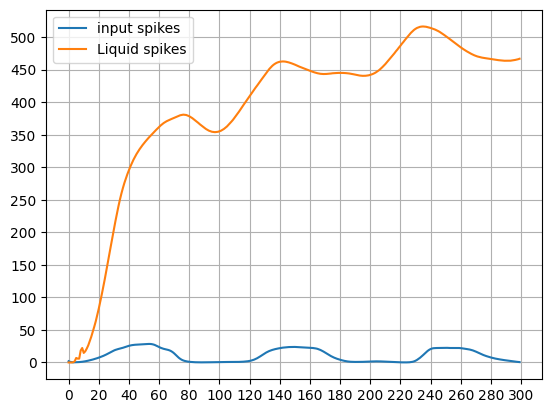

In [ ]:
plt.figure()
plt.grid()
plt.xticks(np.arange(0, 301, 20))
plt.yticks(np.arange(0, 501, 50))
plt.plot(batch_spikes_i)
plt.plot(batch_spikes_l)
plt.legend(['input spikes','Liquid spikes'])
plt.show()

In [ ]:
LSM_out_train_np = np.array(LSM_out_train)
LSM_out_train_reshp = np.reshape(LSM_out_train_np, (LSM_out_train_np.shape[0]*LSM_out_train_np.shape[1],LSM_out_train_np.shape[2]))
LSM_out_test_np = np.array(LSM_out_test)
LSM_out_test_reshp = np.reshape(LSM_out_test_np, (LSM_out_test_np.shape[0]*LSM_out_test_np.shape[1],LSM_out_test_np.shape[2]))

y_train_np = np.array(y_train)
y_test_np = np.array(y_test)
y_train_data = np.int32(np.reshape(y_train_np, (LSM_out_train_np.shape[0]*LSM_out_train_np.shape[1])))
y_test_data = np.int32(np.reshape(y_test_np, (LSM_out_test_np.shape[0]*LSM_out_test_np.shape[1])))

print("mean LSM spiking (train) : ", np.mean(LSM_out_train_np))
print("mean LSM spiking (test) : ", np.mean(LSM_out_test_np))

print("mean input spiking (train) : ", train_mean_spikes)
print("mean input spiking (test) : ", test_mean_spikes)

mean LSM spiking (train) :  0.34765896
mean LSM spiking (test) :  0.34825847
mean input spiking (train) :  0.004667137008315573
mean input spiking (test) :  0.004700006786733866


In [ ]:
data_path = '/content/drive/My Drive/Colab Notebooks/SSNN-BP/'
#np.save(data_path + 'W_in_NMNIST_p2', W_in)
#np.save(data_path + 'W_lsm_NMNIST_p2', W_lsm)
np.save(data_path + 'train_LSM_out_NMNIST_p2', LSM_out_train_reshp)
np.save(data_path + 'train_labels_NMNIST_p2', y_train_data)
np.save(data_path + 'test_LSM_out_NMNIST_p2', LSM_out_test_reshp)
np.save(data_path + 'test_labels_NMNIST_p2', y_test_data)